## Pileup Recognizer

### Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt

### Data Generators

In [22]:
import numba 
from numba import jit

In [27]:
@jit(nopython=True)
def makeNoPileup(amp, T0):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [33]:
wf = makeNoPileup(100,1000)

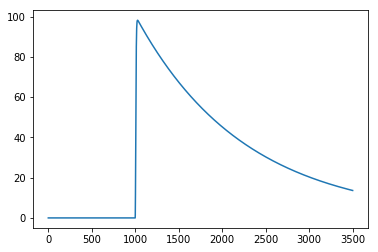

In [34]:
plt.plot(wf)

In [35]:
@jit(nopython=True)
def makePileup(amp, T0, delay, perc):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    amp1 = perc*amp
    ampTotal = amp
    T2 = T0+delay
    for i in range(length):
        
        if i>=T2:
            step[i%2]=1.
        elif i>=T0:
            step[i%2]=perc
        else:
            step[i%2]=0.

        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [36]:
wf = makePileup(100,1000,100,0.5)

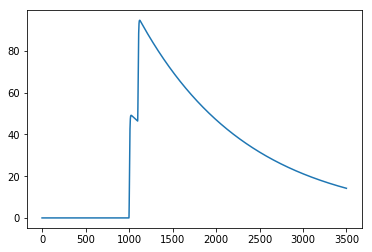

In [37]:
plt.plot(wf)

In [81]:
def genNoisyBatch(N):
    @jit(nopython=True, locals={'makePileup':numba.typeof(makePileup), 'makeNoPileup':numba.typeof(makeNoPileup)})
    
    def genNoNoise(N):
        data = np.empty((N,3500))
        E = np.random.randint(200,2000, size=N)
        T0= np.random.randint(900,1100, size=N)
        p = np.random.random(size=int(N/2))*0.8+0.1
        d = np.random.randint(30,400,size=int(N/2))

        for i in range(int(N/2)):
            data[i] = makeNoPileup(E[i],T0[i])
        for i in range((int(N/2)),N):
            data[i] = makePileup(E[i],T0[i],d[i-int(N/2)], p[i-int(N/2)])
        return data, T0, p, d
    
    compile_gen, _, _, _ = genNoNoise(1)
    
    data, T0, perc, delays = genNoNoise(N)
    
    delays = np.append(np.zeros(int(N/2)), delays)
    perc = np.append(np.zeros(int(N/2)), perc)
    
    
    noise = np.random.normal(scale=20., size=(N,3500))
    
    
    noisyData = data + noise
    
    @jit(nopython=True)
    def scale_it(N, noisyData):
        for i in range(N):
            noisyData[i] = noisyData[i]*2./np.amax(noisyData[i]) - 1.

    scale_it(1, data[:1])
    scale_it(N, noisyData)
    
    #y = np.append(T0.reshape((N,1)), perc.reshape((N,1)), 1)
    #y = np.append(y, delays.reshape((N,1)), 1)
    return noisyData.reshape((N,3500,1)), delays

In [58]:
wf, y = genNoisyBatch(10)

In [59]:
y.shape

(10,)

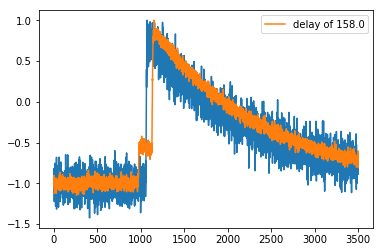

In [60]:
plt.plot(wf[0])
plt.plot(wf[-1], label='delay of '+str(y[-1]))
plt.legend()

In [61]:
def shuffle(data, y):
    rnd_state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rnd_state)
    np.random.shuffle(y)

In [82]:
X, y = genNoisyBatch(1000)

### Come up with a good model for the network

In [83]:
from keras.layers import LeakyReLU
from keras.models import Model
from keras.layers import Input, Dense, Add, BatchNormalization, Conv1D, Flatten

In [100]:
def modelGen(input_shape=(3500,1)):
    X_in = Input(input_shape)
    X = Flatten()(X_in)
    
    
    X = Dense(200)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X_shortcut = X

    X = Dense(200)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Dense(200)(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #X = BatchNormalization()(X)
    
    X = Add()([X, X_shortcut])
    X = Flatten()(X)
    X = Conv1D(128, 128)(X)
 
    X = Dense(1)(X)

    m = Model(inputs=X_in, outputs=X, name="Pileup recognizer")
    m.compile(optimizer='adam', loss='mse')
    return m

In [101]:
m = modelGen()

ValueError: Input 0 is incompatible with layer flatten_11: expected min_ndim=3, found ndim=2

In [86]:
m.fit(X, y)

Epoch 1/1
1000/1000 [==============================] - 0s 242us/step - loss: 26302.4092
